tryed random forest,
Precision (macro): 0.860934
Recall (macro):    0.827522
F1 score (macro):  0.831007
auc:
'micro': 0.9895574070701553,
 'macro': 0.9894005847953218
 
 plus knn and stacking, not well

In [84]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from gensim.models import word2vec
import torch.nn as nn
import torch
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.model_selection import GridSearchCV

In [109]:
data=pd.read_csv('D:\\jupyter notebook\\prediction.csv')

In [104]:
data

,cdr3,crd3_encode,j.segm,v.seg,mhc.a,mhc.b,v.seg_0,v.seg_1,v.seg_2,v.seg_3,...,mhc.a_1,mhc.a_2,mhc.a_3,mhc.a_4,mhc.a_5,mhc.a_6,mhc.b_label,mhc.class,antigen.epitope,vdjdb.score
0,CAAAERNTGELFF,"[-0.16498591005802155, -0.1462753862142563, 0....",TRBJ2-2*01,TRBV28*01,HLA-A*02,B2M,0,1,1,0,...,0,0,0,1,0,0,0,0,YLQPRTFLL,0
1,CAAEDPEWGAEAFF,"[-0.24984240531921387, 0.38962453603744507, -0...",TRBJ1-1*01,TRBV30*01,HLA-A*03:01,B2M,0,1,1,0,...,0,0,1,1,1,1,0,0,KLGGALQAK,0
2,CAAGAGLSYEQYF,"[-0.7613160014152527, 0.263674259185791, -0.52...",TRBJ2-7*01,TRBV27*01,HLA-A*02,B2M,0,1,0,1,...,0,0,0,1,0,0,0,0,NLVPMVATV,0
3,CAAGDANTGELFF,"[-0.7613160014152527, 0.263674259185791, -0.52...",TRBJ2-2*01,TRBV5-1*01,HLA-A*02:01,B2M,0,1,1,1,...,0,0,0,1,0,1,0,0,YLQPRTFLL,0
4,CAAGEMFGLGETQYF,"[-0.7613160014152527, 0.263674259185791, -0.52...",TRBJ2-5*01,TRBV4-2*01,HLA-A*03:01,B2M,0,1,1,1,...,0,0,1,1,1,1,0,0,KLGGALQAK,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29760,CVTGQGDINEQFF,"[0.07739217579364777, 0.0676565170288086, 0.14...",TRBJ2-1*01,TRBV11-1*01,HLA-A*03:01,B2M,0,0,0,1,...,0,0,1,1,1,1,0,0,KLGGALQAK,0
29761,CVTSAPLRQGLFNYGYTF,"[0.17337776720523834, 0.1124500036239624, 0.03...",TRBJ1-2*01,TRBV24-1*01,HLA-A*02,B2M,0,1,0,1,...,0,0,0,1,0,0,0,0,GILGFVFTL,0
29762,CWGNTEAFF,"[-0.13605011999607086, 0.22847767174243927, 0....",TRBJ1-1*01,TRBV12-4*01,HLA-A*03:01,B2M,0,0,1,0,...,0,0,1,1,1,1,0,0,KLGGALQAK,0
29763,IPDTGELFF,"[0.6372780799865723, 0.36321160197257996, 0.24...",TRBJ2-2*01,TRBV3-1*01,HLA-DPA*01:03,HLA-DPB*04:01,0,1,1,0,...,0,1,0,0,1,0,1,1,TFEYVSQPFLMDLE,0


In [110]:
data=data[['cdr3','j.segm','v.seg','mhc.a','mhc.b','antigen.epitope']]

In [111]:
def label(data):
    le = LabelEncoder()
    cat_columns = list(data.select_dtypes(['object']).columns)
    for col in cat_columns:
        data[col] = le.fit_transform(data[col])
        if col=='antigen.epitope':
            res = {}
            for cl in le.classes_:
                res.update({cl:le.transform([cl])[0]})
            print(res)
    return data
data=label(data)
data

{'AVFDRKSDAK': 0, 'ELAGIGILTV': 1, 'FRDYVDRFYKTLRAEQASQE': 2, 'GILGFVFTL': 3, 'GLCTLVAML': 4, 'IVTDFSVIK': 5, 'KLGGALQAK': 6, 'KRWIILGLNK': 7, 'NLVPMVATV': 8, 'RAKFKQLL': 9, 'SPRWYFYYL': 10, 'TFEYVSQPFLMDLE': 11, 'YLQPRTFLL': 12}


,cdr3,j.segm,v.seg,mhc.a,mhc.b,antigen.epitope
0,0,8,21,0,0,12
1,1,0,24,6,0,6
2,2,13,20,0,0,8
3,3,8,28,1,0,12
4,4,11,26,6,0,6
...,...,...,...,...,...,...
29760,27516,7,3,6,0,6
29761,27517,1,18,0,0,3
29762,27518,0,7,6,0,6
29763,27519,8,23,16,1,11


In [99]:
# from collections import Counter
# du=pd.DataFrame(data.groupby(by=['cdr3','j.segm','mhc.a','mhc.b','v.seg'])['antigen.epitope'].count())
# l=[i[0] for i in du[du['antigen.epitope']>1].index]

In [14]:
# data = data[data['antigen.epitope'].map(data['antigen.epitope'].value_counts()) > 20] #drop the clusters with little data

<AxesSubplot:>

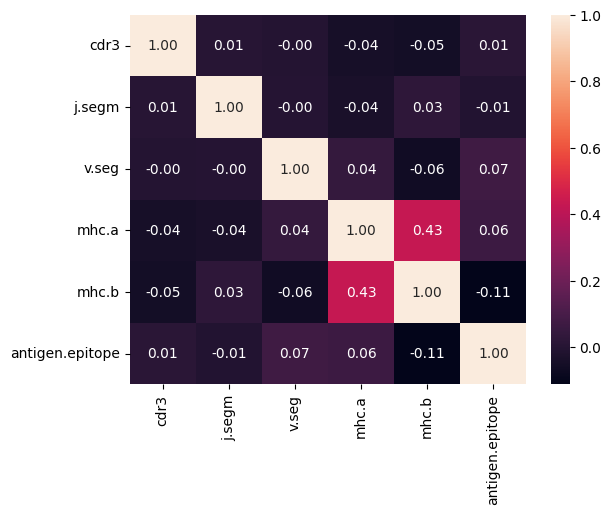

In [15]:
sns.heatmap(data.corr(),annot=True,fmt='.2f')

In [9]:
# data.drop(['complex.id','d.segm','species'],axis=1,inplace=True)

C:\Users\15617\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
train_data, test_data = train_test_split(data, 
                                          stratify=data['antigen.epitope'], 
                                          train_size=0.8, 
                                          test_size=0.2)

In [17]:
X_train=train_data.drop('antigen.epitope',axis=1)
X_test=test_data.drop('antigen.epitope',axis=1)
y_train=train_data['antigen.epitope']
y_test=test_data['antigen.epitope']

最优参数： 31
最高得分： 0.7918696455568621


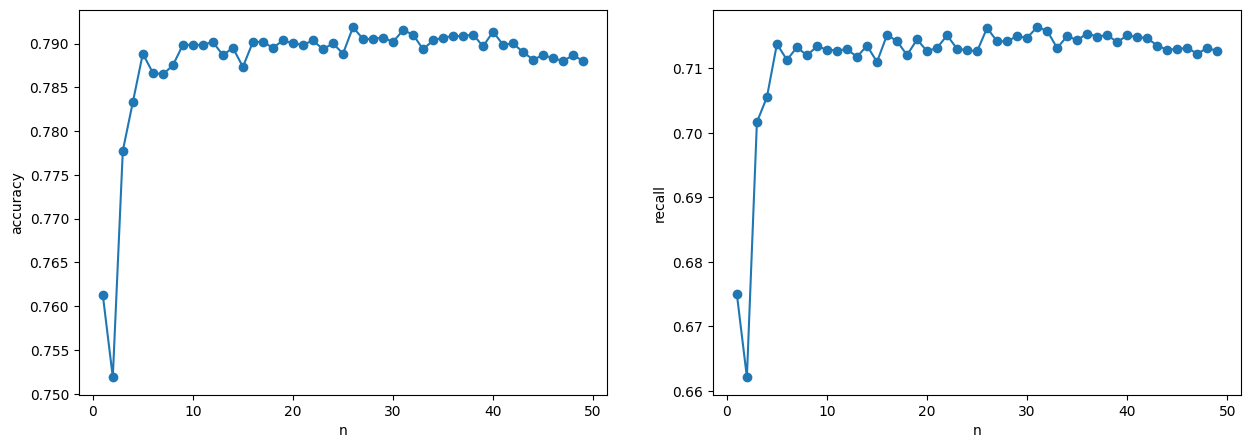

In [18]:

acc_scores=[]
acc_scores1 = []
nrange=range(1,50)
for n in nrange:
    rf = RandomForestClassifier(random_state=1,n_estimators=n)
    rf.fit(X_train, y_train)
    acc_scores.append(rf.score(X_test, y_test))
    acc_scores1.append(recall_score(y_test,rf.predict(X_test),average='macro'))
print("最优参数：",acc_scores1.index(max(acc_scores1))+1)
print("最高得分：",max(acc_scores))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.xlabel('n')
plt.ylabel('accuracy')
plt.plot(nrange, acc_scores, marker='o')
plt.subplot(122)
plt.xlabel('n')
plt.ylabel('recall')
plt.plot(nrange, acc_scores1, marker='o')


In [63]:
param_grid = {'max_depth':np.arange(1, 20, 1)}
rfc = RandomForestClassifier(n_estimators=31
                             ,random_state=90
                             )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X_train, y_train)
GS.best_params_

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=31, random_state=90),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [65]:
GS.best_score_

0.8216023790355427

In [69]:
param_grid = {'max_features':np.arange(2,10,1)}
rfc = RandomForestClassifier(n_estimators=31
                             ,random_state=90,
                             max_depth=11
                             )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X_train, y_train)
GS.best_params_

{'max_features': 2}

In [70]:
GS.best_score_

0.8216023790355427

In [71]:
rf = RandomForestClassifier(random_state=23,n_estimators=31,max_depth=11,max_features=2)
rf.fit(X_train, y_train)
pre=rf.predict(X_test)
print("Precision (macro): %f" % precision_score(y_test, pre, average='macro'))
print("Recall (macro):    %f" % recall_score(y_test, pre, average='macro'))
print("F1 score (macro):  %f" % f1_score(y_test, pre, average='macro'), end='\n\n')
confusion_matrix_result = metrics.confusion_matrix(pre,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

Precision (macro): 0.813458
Recall (macro):    0.722513
F1 score (macro):  0.718749

The confusion matrix result:
 [[ 330    0    0    0    0  110    0    0    0    0    0    0    0]
 [   0   25    0   15    7    0    0    0   22    0    0    0    5]
 [   0    0   89    0    0    0    0    0    0    0    0    0    0]
 [   0   33    0  432   53    0    0    0   74    0    0    0   25]
 [   0   11    0   48   93    0    0    0   24    0    0    0   13]
 [   0    0    0    0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 2548    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0   97    0    0    0    0    0]
 [   0  214    0  248   61    0    0    0  814    3    0    0   62]
 [   0    0    0    0    0    0    0    0    0  171    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0  108    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0   91    0]
 [   0    6    0    5    3    0    0    0   21    1    0    0   90]]


In [83]:
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_test, classes=np.arange(num_classes))
y_pred_bin = label_binarize(pre, classes=np.arange(num_classes))

# 计算多分类的 AUC（macro 平均）
Auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro')

print("Macro-average AUC:", Auc)

# 如果你想查看每个类别的 AUC，使用 'None'
auc_per_class = roc_auc_score(y_true_bin, y_pred_bin, average=None)

print("AUC per class:", auc_per_class)

Macro-average AUC: 0.8533950405638746
AUC per class: [0.99021874 0.53892703 1.         0.77099868 0.70591751 0.5045045
 1.         1.         0.86735448 0.98857143 1.         1.
 0.72764315]


In [73]:
num_classes=13

In [85]:
def get_roc_auc(trues, preds):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #print(trues, preds)
    y_label=np.eye(13)
    print(y_label)
    
    y_score=metrics.confusion_matrix(preds,y_test)
    print(y_score)
    y_true_bin = label_binarize(trues, classes=np.arange(num_classes))
    y_pred_bin = label_binarize(preds, classes=np.arange(num_classes))

    # 计算 FPR 和 TPR，并计算 AUC
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])

#     for i in range(num_classes):
#         fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_score.ravel())
    print(fpr["micro"], tpr["micro"])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    #plt.legend(loc="lower right")
    plt.savefig("ROC_13分类.png")
    plt.show()

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[ 330    0    0    0    0  110    0    0    0    0    0    0    0]
 [   0   25    0   15    7    0    0    0   22    0    0    0    5]
 [   0    0   89    0    0    0    0    0    0    0    0    0    0]
 [   0   33    0  432   53    0    0    0   74    0    0    0   25]
 [   0   11    0   48   93    0    0    0   24    0    0    0   13]
 [   0    0    0    0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 2548    0    

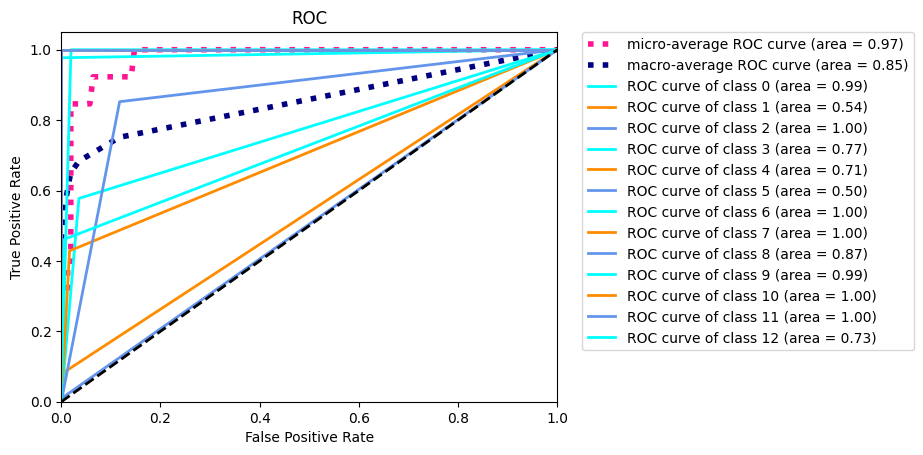

In [86]:
get_roc_auc(y_test, pre)

In [43]:
np.shape(pre)

(15525,)

Max accuracy score: 0.7263276064037485


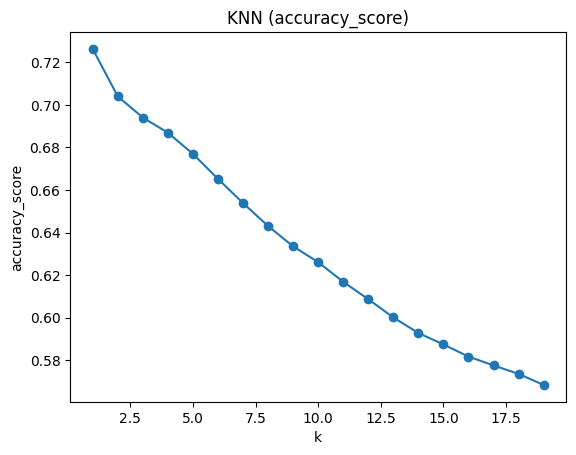

In [24]:
from sklearn.neighbors import KNeighborsClassifier
t_range = range(1, 20)
acc_scores = []
for t in t_range:
    clf = KNeighborsClassifier(n_neighbors=t)
    clf = clf.fit(X_train, y_train)
    acc_scores.append(metrics.accuracy_score(y_test,clf.predict(X_test)))
print('Max accuracy score:',max(acc_scores))    
plt.xlabel('k')
plt.ylabel('accuracy_score')
plt.title('KNN (accuracy_score)')
plt.plot(t_range, acc_scores, marker='o')

In [25]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1,n_estimators=48)
clf3 = SVC()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)
 
print('3-fold cross validation:\n')
 
for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'SVC',
                       'StackingClassifier']):
 
    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:



D:\python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Accuracy: 0.69 (+/- 0.02) [KNN]


D:\python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Accuracy: 0.90 (+/- 0.01) [Random Forest]


D:\python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Accuracy: 0.34 (+/- 0.00) [SVC]


D:\python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
D:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please 

Accuracy: 0.59 (+/- 0.02) [StackingClassifier]
